<a href="https://colab.research.google.com/github/redrum88/tensorflow/blob/main/08_introduction_to_nlp_in_tensorflow_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to NLP Fundementals in TensorFlow

NLP has the goal of deriving information out of natural language (could be sequences text or speech)

Another common term for NLP is sequence to sequence problems (seq2seq)

## Check for GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-6d8935d4-f6b3-2c1a-34f0-b0e9d8b95667)


## Get helper functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-02-28 11:59:12--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-28 11:59:12 (75.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper function for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

## Get a text dataset

The dataset we're going to be using is Kaggle's introduction to NLP dataset (text samples of Tweets labelled as disaster or not disaster).

See the original source here: https://www.kaggle.com/competitions/nlp-getting-started/overview


In [4]:
# Unzip data
unzip_data("nlp-getting-started.zip")

## Visualizing a text dataset

To visualize our text samples, we first have to read them in, one way to do so would be Python.

But I prefer to get visual straight away.

So another way to do this is to use pandas...

In [5]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [7]:
# What does the test dataframe look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [9]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [10]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not highher
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0 (not real disaster)
Text:
Truck Driver Salvages Banned Tomatoes From Destruction on #Russian Border http://t.co/7b2Wf6ovFK #news

---

Target: 1 (real disaster)
Text:
Traffic accident N CABRILLO HWY/MAGELLAN AV MIR (08/06/15 11:03:58)

---

Target: 0 (not real disaster)
Text:
@cameronhigdon34 I can't drown my demons they know how to swim.

---

Target: 0 (not real disaster)
Text:
@optich3cz #askH3cz i'm jealous now. Bc i wanted a elgato hd for my bday so i can record videos but i didnt have the money for it.

---

Target: 1 (real disaster)
Text:
If abortion is murder then blowjobs are cannibalism and masturbation is mass genocide.

---



### Split data into training and validation sets

In [11]:
from sklearn.model_selection import train_test_split


In [12]:
# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)

In [13]:
# Check the lenghts
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [14]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## Converting text into numbers

When dealing with a text problem, one of the first things you'll have to do before you can build a model is to convert your text to numbers.

There are a few ways to do this, namely:
* Tokenization - direct mapping of token (a token could be a word or a character) to number
* Embedding - create a matrix of feature vector for each token (the size of the feature vector can be defined and this embedding can be learned)

### Text vectorization (tokenization)

In [15]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=10000, # how many words in the vocabulary (automatically add <OOV>)
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None, # how long do you want your sequences to be? 
                                    pad_to_max_tokens=True)

In [16]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [17]:
# Setup text vectorization variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does a model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [18]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [19]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [20]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}")
print(f"Vectorized version:")
text_vectorizer([random_sentence])

Original text:
 @PrablematicLA @Adweek I'm actually currently dressed for a snowstorm...despite being in the middle of a Texas summer. Thanks office A/C.
Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[9631,    1,   32,  633, 1420, 5773,   10,    3, 8341,  121,    4,
           2, 1073,    6,    3]])>

In [21]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in  our training data
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:] # get the least common words
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 most common words: {top_5_words}")
print(f"5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding Layer

To make our embedding, we're going to use TensorFlow's embedding Layer

The parameters we care most about for our embedding layer:
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector, for example, a value of 100 would mean each token gets represented by a vector 100 long
* `input_length` = length of the sequences being passed to the embedding layer


In [22]:
from tensorflow.keras import layers
embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             input_length=max_length)

embedding

In [23]:
# Get a random sentence from the training set
random_sentence =  random.choice(train_sentences)
print(f"Original text:\n {random_sentence}")
print(f"Embedded version:")

# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 Maxsys is hiring a #Demolition #Workers apply now! #Halifax #jobs http://t.co/QTIZcBWw7G
Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.01769407,  0.00742783,  0.02334877, ..., -0.03788679,
         -0.01962194, -0.03894836],
        [-0.04482577, -0.00472746,  0.00623845, ...,  0.04813543,
          0.03543418,  0.00319801],
        [ 0.04908277, -0.04900347,  0.03397354, ..., -0.00073301,
         -0.0277126 ,  0.01630265],
        ...,
        [ 0.03868056, -0.03722169, -0.00455349, ..., -0.04519821,
         -0.01296293,  0.03329277],
        [ 0.03868056, -0.03722169, -0.00455349, ..., -0.04519821,
         -0.01296293,  0.03329277],
        [ 0.03868056, -0.03722169, -0.00455349, ..., -0.04519821,
         -0.01296293,  0.03329277]]], dtype=float32)>

In [24]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence[0]

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.01769407,  0.00742783,  0.02334877,  0.04174428, -0.01196913,
        -0.00590557, -0.01599441,  0.04959562,  0.02760128,  0.00710721,
         0.00029211, -0.00793853,  0.01150496,  0.01528994,  0.01162214,
        -0.00936036, -0.0474265 , -0.00898515,  0.0338384 ,  0.03823088,
        -0.0439751 ,  0.03772017,  0.03550682, -0.03466419, -0.01165747,
         0.04584384,  0.04748273,  0.04958259, -0.01735674, -0.01836846,
         0.03218857,  0.03287443,  0.04887028,  0.01406359, -0.01224007,
        -0.03336436, -0.01751984,  0.02633471,  0.0026345 , -0.03688421,
        -0.0073534 , -0.01627624,  0.03025987,  0.0024811 ,  0.04018337,
         0.02391151,  0.01162394, -0.0424149 ,  0.04126972,  0.02659014,
         0.03050571,  0.02450415,  0.03131901, -0.049291  , -0.02959356,
         0.03331259, -0.03892573,  0.03594599, -0.03510709,  0.02358732,
         0.03147782,  0.0034863 , -0.04470992, -0.03359791, -0.00751538,
  

## Modelling a text dataset (running a series of experiments)

Now we've got a way to turn our text sequences into numbers,
it's time to start building a series of modelling experiments.

We'll start with a baseline and move on from there.

* Model 0: Naive bayes (baseline)
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirection-LSTM model (RNN)
* Model 5: 1D Convolutional Neural Network (CNN)
* Model 6: TensorFlow Hub Pretrained Feature Extractor (using transfer learning for NLP)
* Model 7: Same as model 6 with 10% of training data

How are we going to approach all of these?

Use the standard steps in modelling with TensorFlow:

* Create a model
* Build a model
* Fit a model
* Evaluate our model

### Model 0: Getting a baseline

As with all machine learning modelling experiments, it's important to create a baseline model so you've got a benchmark for future experiments to build upon.

To create our baseline, we'll use Sklearn's Multinomial Naive Bayes using the TF-IDF formula to convert our words to numbers.

>🔑**Note:** It's common practice to use non-DL algorithms as a baseline because of their speed and then later using DL to see if you can improve upon them.

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [26]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [27]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

from pandas.core.arrays.timedeltas import precision_from_unit
### Creating an evaluation function for our model experiments

We could evaluate all of our model's predictions with different metrics every time, however, this will be cumbersome and could work with a function...

Let's create one to compare our model's predictions with the truth labels using the following metrics:
* Accuracy
* Precision
* Recall
* F1-score

For a deep overview of many different evaluaten methods, see the Sklearn documentation


In [28]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1-score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1": model_f1}
  return model_results

In [29]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 1: A simple dense model

In [30]:
# Create a tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create a directory to save TensorBoard logs
SAVE_DIR = "model_logs"


In [31]:
# build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numberized inputs
x = layers.GlobalAveragePooling1D()(x) # condense the feature vector for each token to one vector
outputs = layers.Dense(1, activation="sigmoid")(x) # Create the output layer,
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [32]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [33]:
# Compile model
model_1.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [34]:
# Fit the model
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20230228-115944
Epoch 1/5
215/215 [==============================] - 16s 50ms/step - loss: 0.6108 - accuracy: 0.6903 - val_loss: 0.5361 - val_accuracy: 0.7520
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4410 - accuracy: 0.8174 - val_loss: 0.4682 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.3465 - accuracy: 0.8608 - val_loss: 0.4568 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.2837 - accuracy: 0.8915 - val_loss: 0.4592 - val_accuracy: 0.7874
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.2372 - accuracy: 0.9104 - val_loss: 0.4796 - val_accuracy: 0.7808


In [35]:
# Check the results
model_1.evaluate(val_sentences, val_labels)


24/24 [==============================] - 0s 3ms/step - loss: 0.4796 - accuracy: 0.7808


[0.47959834337234497, 0.7808399200439453]

In [36]:
# Make some predictions and evaluate those
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

24/24 [==============================] - 0s 5ms/step


(762, 1)

In [37]:
model_1_pred_probs[0]

array([0.3735847], dtype=float32)

In [38]:
# Convert model prediction probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [39]:
# Calculate our model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.08398950131233,
 'precision': 0.7852692803643447,
 'recall': 0.7808398950131233,
 'f1': 0.77783229852174}

In [40]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

In [41]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

## Visualizing learned embeddings

In [42]:
# Get the vocavulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [43]:
max_vocab_length

10000

In [44]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [45]:
# Get the weight matrix of embedding layer
# (these are the numerical representations of each token in our training data, which have been learned for 5 epochs)
embed_weights = model_1.get_layer("embedding").get_weights()[0]
embed_weights

array([[ 0.05712301, -0.02021123, -0.02301606, ..., -0.03591293,
        -0.03197782,  0.01888001],
       [ 0.02258881,  0.01276651,  0.01672172, ..., -0.0410036 ,
        -0.0239027 , -0.03768164],
       [-0.02297702,  0.04118482,  0.00144037, ..., -0.00799964,
        -0.05260181,  0.04181304],
       ...,
       [-0.02041217, -0.01426202,  0.02950687, ..., -0.00747976,
        -0.0446927 , -0.02897829],
       [ 0.07909987,  0.05052563,  0.01119459, ...,  0.04608626,
        -0.0745118 , -0.00837519],
       [ 0.02463378,  0.09454185, -0.02859956, ...,  0.08727506,
        -0.0606237 , -0.04134186]], dtype=float32)

Now we've got the embedding matrix our model has learned to represent our tokens, let's see how we can visualize it.

To do so, TensorFlow has a handy tool called projector: https://projector.tensorflow.org/

And TensorFlow also has an increadible guide on word embeddings themselves: https://www.tensorflow.org/text/guide/word_embeddings

In [46]:
embed_weights.shape

(10000, 128)

In [47]:
# Create embedding files (we got this from TensorFlow's word embeddings documentation)
import io
out_v = io.open("vectors.tsv", "w", encoding="utf-8")
out_m = io.open("metadata.tsv", "w", encoding="utf-8")

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [48]:
# Download files from Colab to upload to projector
try:
  from google.colab import files
  files.download("vectors.tsv")
  files.download("metadata.tsv")
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading files above we can visualize them using http://projector.tensorflow.org and  click the "load" button on the left hand side.

## Recurrent Neural Networks (RNN's)

RNN's are useful for sequence data.

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input.

> **Resources:** If you want an overview of the internals of a recurrent neural network, see the following:
- MIT's sequence modelling lecture https://www.youtube.com/watch?v=qjrad0V0uJE
- Chris Olah's intro to LSTM: https://colah.github.io/posts/2015-08-Understanding-LSTMs/
- Andrej Karpathy's the unreasonable effectiveness of RNN's: http://karpathy.github.io/2015/05/21/rnn-effectiveness/

### Model 2: LSTM

LSTM = long short term memory (one of the most popular LSTM cells)

Our structure of an RNN typically looks like this:

```
Input (text) -> Tokenize -> Embedding -> Layers (RNNs/dense) -> Output (label probability)
```

In [49]:
# Create an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)
# x = layers.LSTM(units=64, return_sequences=True)(x)
# print(x.shape)
x = layers.LSTM(64)(x)
# print(x.shape)
# x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")


In [50]:
# Get a summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [51]:
# Compile the model
model_2.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [52]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20230228-120013
Epoch 1/5
215/215 [==============================] - 13s 41ms/step - loss: 0.2228 - accuracy: 0.9218 - val_loss: 0.5332 - val_accuracy: 0.7835
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1542 - accuracy: 0.9422 - val_loss: 0.6134 - val_accuracy: 0.7769
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1270 - accuracy: 0.9523 - val_loss: 0.7642 - val_accuracy: 0.7769
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.1024 - accuracy: 0.9610 - val_loss: 0.9753 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0815 - accuracy: 0.9685 - val_loss: 0.9643 - val_accuracy: 0.7703


In [53]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 1s 5ms/step


array([[2.9060689e-03],
       [6.6558105e-01],
       [9.9983931e-01],
       [1.0766206e-01],
       [4.3776608e-04],
       [9.9919051e-01],
       [8.9998347e-01],
       [9.9990225e-01],
       [9.9980742e-01],
       [4.7390118e-01]], dtype=float32)

In [54]:
# Convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [55]:
model_2_results = calculate_results(val_labels, model_2_preds)
model_2_results

{'accuracy': 77.03412073490814,
 'precision': 0.7729377683268125,
 'recall': 0.7703412073490814,
 'f1': 0.7677842762403819}

from types import UnionType
### Model 3: GRU

Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has similar features to an LSTM cell but has less parameters.


In [56]:
# Build an RNN using the GRU cell
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64, return_sequences=True)(x) # if you want to stack recurrent layers on top of each other, you need return_sequences=True
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.GRU(64)(x)
x = layers.Dense(64, activation="relu")(x)
# x = layers.GlobalAveragePooling1D()(x)
ouputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, ouputs, name="model_3_GRU")

In [57]:
# Get a summary
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 15, 64)            37248     
                                                                 
 lstm_1 (LSTM)               (None, 15, 64)            33024     
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                       

In [58]:
# Compile the model
model_3.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, experiment_name="model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20230228-120037
Epoch 1/5
215/215 [==============================] - 16s 47ms/step - loss: 0.1365 - accuracy: 0.9566 - val_loss: 0.7917 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0795 - accuracy: 0.9695 - val_loss: 1.0385 - val_accuracy: 0.7703
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0633 - accuracy: 0.9711 - val_loss: 1.2520 - val_accuracy: 0.7690
Epoch 4/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0595 - accuracy: 0.9727 - val_loss: 1.3913 - val_accuracy: 0.7703
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0530 - accuracy: 0.9747 - val_loss: 1.2902 - val_accuracy: 0.7703


In [59]:
# Make some predictions withour GRU model
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 [==============================] - 1s 5ms/step


array([[1.1696890e-02],
       [6.7208666e-01],
       [9.9997985e-01],
       [5.2105293e-02],
       [9.0408495e-05],
       [9.9986005e-01],
       [9.9834132e-01],
       [9.9997187e-01],
       [9.9995744e-01],
       [9.5898211e-01]], dtype=float32)

In [60]:
# Convert model 3 pred probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [61]:
# Calculate model 3 results
model_3_results = calculate_results(val_labels, model_3_preds)
model_3_results

{'accuracy': 77.03412073490814,
 'precision': 0.7699718413593212,
 'recall': 0.7703412073490814,
 'f1': 0.7699305904476158}

### Model 4: Bidirectional RNN

Normal RNN's go from left to right (just like you'd read an English sentence) however, a bidirectional RNN goes from right to left as well as left to right.

In [62]:
# Build a bidirectional RNN in TensorFlow
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.GRU(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

In [63]:
# Get a summary
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 15, 128)          98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              74496     
 nal)                                                            
                                             

In [64]:
# Compile the model
model_4.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, experiment_name="model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20230228-120125
Epoch 1/5
215/215 [==============================] - 18s 49ms/step - loss: 0.1038 - accuracy: 0.9656 - val_loss: 1.0596 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0532 - accuracy: 0.9761 - val_loss: 1.1761 - val_accuracy: 0.7743
Epoch 3/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0457 - accuracy: 0.9788 - val_loss: 1.3001 - val_accuracy: 0.7690
Epoch 4/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0450 - accuracy: 0.9793 - val_loss: 1.4511 - val_accuracy: 0.7690
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0411 - accuracy: 0.9807 - val_loss: 1.3098 - val_accuracy: 0.7795


In [65]:
# Make predictions with our bidirectional model
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 2s 7ms/step


array([[1.4394015e-02],
       [7.9642427e-01],
       [9.9994886e-01],
       [6.9607049e-02],
       [3.5299821e-05],
       [9.9992454e-01],
       [8.2631028e-01],
       [9.9997461e-01],
       [9.9992836e-01],
       [9.4218016e-01]], dtype=float32)

In [66]:
# Convert pred probs to pred labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [67]:
# Calculate the results of our bidirectional model
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 77.95275590551181,
 'precision': 0.7813761276529175,
 'recall': 0.7795275590551181,
 'f1': 0.7775281328700309}

## Convolution Neural Networks for Text (and other types of sequences)

We've used CNNs for images but images are typically 2D (height x width)...  however, our text data is 1D.

Previously we've `Conv2D` for our image data but now we're going to use `Conv1D`.

The typical structure of a Conv1D model for sequences (in our case, text):

```
Inputs (text) -> Tokenization -> Embedding -> Layers (typically Conv1D + pooling) -> Outputs (class probabilities)
```

### Model 5: Conv1D

In [68]:
# Test out our embedding layer, Conv1D layer and max pooling
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sequence into enbedding
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5, # this is also referred to as an ngram of 5 (meaning it looks at 5 words at time)
                        activation="relu",
                        padding="valid")
conv_1d_output = conv_1d(embedding_test) # pass test embedding through conv1d layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # equivalent to "get the most important feature" or "get the feature with the highest value"

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [69]:
embedding_test

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.02539773,  0.02301867,  0.00925661, ..., -0.01101568,
         -0.02896987,  0.03469401],
        [-0.01302221, -0.01108935,  0.00046294, ...,  0.12745278,
          0.01202173, -0.0735567 ],
        [ 0.02769238, -0.07209174, -0.00964975, ...,  0.05571778,
         -0.02358398, -0.04859868],
        ...,
        [ 0.0385526 , -0.03263532, -0.00475124, ...,  0.00088323,
         -0.01884955,  0.00307046],
        [ 0.0385526 , -0.03263532, -0.00475124, ...,  0.00088323,
         -0.01884955,  0.00307046],
        [ 0.0385526 , -0.03263532, -0.00475124, ...,  0.00088323,
         -0.01884955,  0.00307046]]], dtype=float32)>

In [70]:
conv_1d_output

<tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
array([[[0.        , 0.0031425 , 0.04753342, 0.00685965, 0.        ,
         0.01636801, 0.03346492, 0.04991745, 0.02326398, 0.        ,
         0.        , 0.        , 0.        , 0.02911885, 0.        ,
         0.        , 0.        , 0.02596233, 0.02023108, 0.        ,
         0.03037657, 0.        , 0.        , 0.        , 0.00734046,
         0.        , 0.06637503, 0.01810108, 0.        , 0.        ,
         0.        , 0.05815656],
        [0.01512155, 0.05782813, 0.0558611 , 0.04819783, 0.01819974,
         0.00880597, 0.05464346, 0.        , 0.        , 0.        ,
         0.        , 0.02622977, 0.        , 0.01229499, 0.        ,
         0.02859539, 0.        , 0.04005701, 0.        , 0.        ,
         0.06403139, 0.        , 0.        , 0.04078767, 0.        ,
         0.        , 0.01219502, 0.0140289 , 0.        , 0.        ,
         0.        , 0.06539416],
        [0.05499425, 0.        , 0.03856599, 0.0012

In [71]:
# Build model 5
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  strides=1,
                  padding="valid",
                  activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_conv1d")

In [72]:
# Get a summary
model_5.summary()

Model: "model_5_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_5 (Dense)             (None, 1)              

In [73]:
# Compile the model
model_5.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     experiment_name="model_5_conv1d")])

Saving TensorBoard log files to: model_logs/model_5_conv1d/20230228-120217
Epoch 1/5
215/215 [==============================] - 11s 40ms/step - loss: 0.1288 - accuracy: 0.9555 - val_loss: 0.8973 - val_accuracy: 0.7703
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0741 - accuracy: 0.9729 - val_loss: 1.0377 - val_accuracy: 0.7664
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0622 - accuracy: 0.9768 - val_loss: 1.1219 - val_accuracy: 0.7625
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0564 - accuracy: 0.9764 - val_loss: 1.1608 - val_accuracy: 0.7585
Epoch 5/5
215/215 [==============================] - 2s 7ms/step - loss: 0.0518 - accuracy: 0.9799 - val_loss: 1.2273 - val_accuracy: 0.7585


In [74]:
# Make some preditions with our Conv1D model
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[3.4547395e-01],
       [7.2763026e-01],
       [9.9993920e-01],
       [2.5336310e-02],
       [1.9890257e-07],
       [9.9180448e-01],
       [9.7199482e-01],
       [9.9996340e-01],
       [9.9999940e-01],
       [9.2322826e-01]], dtype=float32)

In [75]:
# Convert  model 5 pred probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [76]:
# Evaluate model 5 predictions
model_5_results = calculate_results(val_labels, model_5_preds)
model_5_results

{'accuracy': 75.8530183727034,
 'precision': 0.7583857376990771,
 'recall': 0.7585301837270341,
 'f1': 0.75741871177066}

## Model 6: TensorFlow Hub Pretrained Sentence Encoder

Now we've build a feew of our own models, let's try and use transfer learning for NLP, specifically using TensorFlow Hub's Universal Sentence Encoder https://tfhub.dev/google/universal-sentence-encoder/4

In [77]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,
                       " When you can the universal sentence encoder on a sentence, it turns it into numbers."])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157028  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680984  0.05589836 -0.0106873  -0.00597291  0.00639323 -0.01819518
  0.00030813  0.09105888  0.05874644 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865347 -0.04209306  0.02678981  0.03011006  0.00321069
 -0.00337973 -0.04787357  0.0226672  -0.00985925 -0.04063613 -0.01292092
 -0.04666384  0.05630299 -0.03949255  0.00517686  0.02495829 -0.0701444
  0.02871508  0.04947684 -0.00633979 -0.08960192  0.02807118 -0.00808364
 -0.01360602  0.0599865  -0.10361787 -0.05195374  0.00232954 -0.02332531
 -0.03758105  0.03327728], shape=(50,), dtype=float32)


In [78]:
# Create a Keras Layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [86]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

In [87]:
# Compile the model
model_6.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "model_6_USE")])

Saving TensorBoard log files to: model_logs/model_6_USE/20230228-124006
Epoch 1/5
215/215 [==============================] - 6s 16ms/step - loss: 0.5079 - accuracy: 0.7846 - val_loss: 0.4482 - val_accuracy: 0.8031
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4154 - accuracy: 0.8123 - val_loss: 0.4397 - val_accuracy: 0.8123
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4010 - accuracy: 0.8228 - val_loss: 0.4310 - val_accuracy: 0.8150
Epoch 4/5
215/215 [==============================] - 3s 16ms/step - loss: 0.3941 - accuracy: 0.8285 - val_loss: 0.4286 - val_accuracy: 0.8150
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3864 - accuracy: 0.8311 - val_loss: 0.4252 - val_accuracy: 0.8202


In [88]:
# Make predictions with USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 11ms/step


array([[0.19858743],
       [0.82658005],
       [0.98883635],
       [0.22191878],
       [0.7520773 ],
       [0.7796079 ],
       [0.9833624 ],
       [0.9857717 ],
       [0.9532027 ],
       [0.10217782]], dtype=float32)

In [89]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [90]:
# Calculate model 6 performance results
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 82.02099737532808,
 'precision': 0.8203268011302447,
 'recall': 0.8202099737532809,
 'f1': 0.8196367915730206}

In [91]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

## Model 7: Tf Hub Pretrained USE but with 10% of training data

Transfer learning really helps when you don't have a large dataset.

To see how our model performs on a smaller dataset, let's replicate `model_6` except we'll train it on 10% of the data.


In [93]:
# ## NOTE: Making data splits like below leads to data leakage (model_7 trained on 10% data, outperforms model_6 trained on all data.)
# ## DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/TEST SETS INTO TRAINING SET

# # Create subsets of 10% of the training data
# train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
# train_sentences_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()
# len(train_sentences_10_percent), len(train_labels_10_percent)

(761, 761)

🔑 **Note:** Be *very* careful when creating training/val/test splits that you don't leak data across the datasets, otherwise your model evaluation metrics will be wrong. If something looks too good to be true (a model trained on 10% of data outperforming the same model trained on 100% of data) trust your gut and go back through to find where the error may lie.

In [106]:
# Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]
     


In [107]:
# Check the number of each label in the updated training data subset
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [108]:
# Check the number of targets in our subset of data
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [109]:
# Build a model 7
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "model_7_USE_10_percent_data")])

Saving TensorBoard log files to: model_logs/model_7_USE_10_percent_data/20230228-135217
Epoch 1/5
22/22 [==============================] - 4s 47ms/step - loss: 0.6735 - accuracy: 0.6526 - val_loss: 0.6573 - val_accuracy: 0.6929
Epoch 2/5
22/22 [==============================] - 1s 27ms/step - loss: 0.6110 - accuracy: 0.8102 - val_loss: 0.6040 - val_accuracy: 0.7546
Epoch 3/5
22/22 [==============================] - 1s 27ms/step - loss: 0.5379 - accuracy: 0.8146 - val_loss: 0.5496 - val_accuracy: 0.7730
Epoch 4/5
22/22 [==============================] - 1s 24ms/step - loss: 0.4749 - accuracy: 0.8248 - val_loss: 0.5120 - val_accuracy: 0.7782
Epoch 5/5
22/22 [==============================] - 0s 23ms/step - loss: 0.4306 - accuracy: 0.8277 - val_loss: 0.4923 - val_accuracy: 0.7795


In [110]:
# Make predictions
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 10ms/step


array([[0.24438685],
       [0.610464  ],
       [0.90472585],
       [0.36033934],
       [0.55824834],
       [0.6778977 ],
       [0.8516743 ],
       [0.78046906],
       [0.8412373 ],
       [0.15146293]], dtype=float32)

In [111]:
# Convert prediction probabilities to prediction labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [112]:
# Check results of model 7
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 77.95275590551181,
 'precision': 0.7799065773530309,
 'recall': 0.7795275590551181,
 'f1': 0.7783167829714759}

In [113]:
model_6_results

{'accuracy': 82.02099737532808,
 'precision': 0.8203268011302447,
 'recall': 0.8202099737532809,
 'f1': 0.8196367915730206}

## Comparing the performance of each of our models

In [120]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_lstm": model_2_results,
                                  "3_gru": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_conv1d": model_5_results,
                                  "6_tf_hub_use_encoder": model_6_results,
                                  "7_tf_hub_use_endoder_10_percent": model_7_results})
all_model_results

,0_baseline,1_simple_dense,2_lstm,3_gru,4_bidirectional,5_conv1d,6_tf_hub_use_encoder,7_tf_hub_use_endoder_10_percent
accuracy,79.265092,78.083990,77.034121,77.034121,77.952756,75.853018,82.020997,77.952756
precision,0.811139,0.785269,0.772938,0.769972,0.781376,0.758386,0.820327,0.779907
recall,0.792651,0.780840,0.770341,0.770341,0.779528,0.758530,0.820210,0.779528
f1,0.786219,0.777832,0.767784,0.769931,0.777528,0.757419,0.819637,0.778317


In [121]:
all_model_results = all_model_results.transpose()

In [122]:
# Reduce the accuracy to the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.780840,0.785269,0.780840,0.777832
2_lstm,0.770341,0.772938,0.770341,0.767784
3_gru,0.770341,0.769972,0.770341,0.769931
4_bidirectional,0.779528,0.781376,0.779528,0.777528
5_conv1d,0.758530,0.758386,0.758530,0.757419
6_tf_hub_use_encoder,0.820210,0.820327,0.820210,0.819637
7_tf_hub_use_endoder_10_percent,0.779528,0.779907,0.779528,0.778317


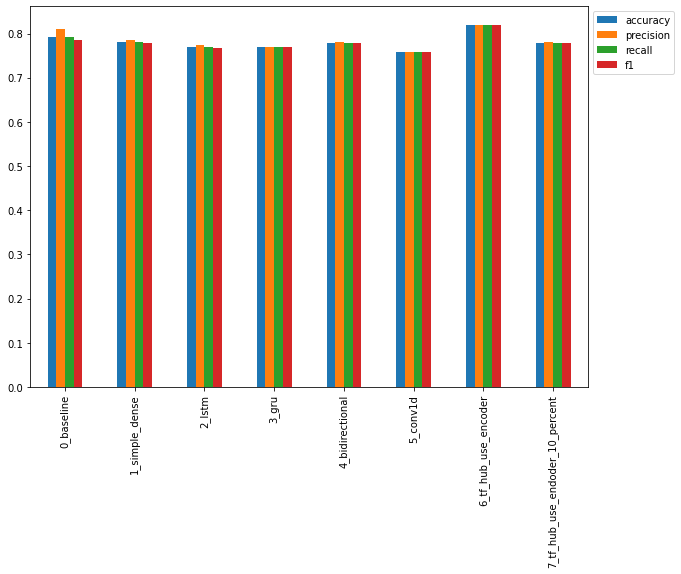

In [123]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

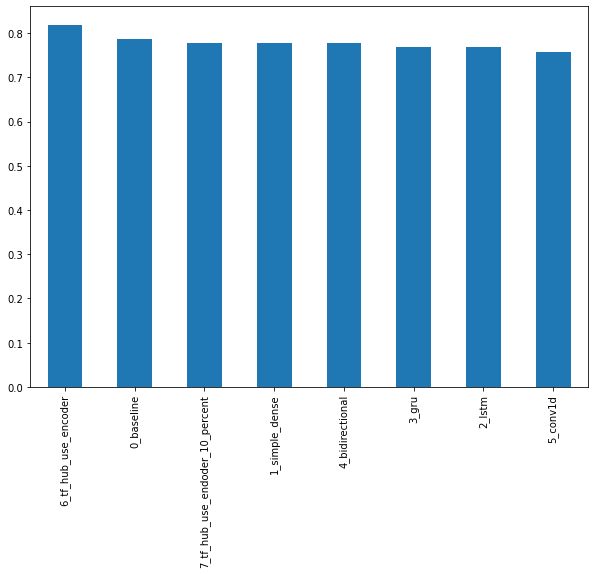

In [124]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

## Uploading our model training logs to TensorBoard.dev
We can further inspect our model's performance using https://tensorboard.dev/


In [127]:
# View TensorBoard logs of transfer learning modelling experiments (plus all of our other models)
# Upload TensorBoard dev records
# !tensorboard dev upload --logdir ./model_logs/ \
#   --name "NLP Modelling Experiments ZTM TF Course Video" \
#   --description "Compering multiple different types of model architectures on the Kaggle text classification dataset" \
#   --one_shot # exit the uploader once uploading is finished

Now I've ran the cell above, my modelling experiments are visible on TensorBoard.dev:
https://tensorboard.dev/experiment/MMfOlD1CQ128bxHkHWw7Vg/

## Saving and loading a trained model

There are two main formats to save a model to in TensorFlow:
1. The HDF5 format
2. The `SavedModel` format (this is the default when using TensorFlow)

In [128]:
model_6_results

{'accuracy': 82.02099737532808,
 'precision': 0.8203268011302447,
 'recall': 0.8202099737532809,
 'f1': 0.8196367915730206}

In [129]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

In [130]:
# Load model with custom Hub Layer (required HDF5 format)
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [131]:
# How does  our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4252 - accuracy: 0.8202


[0.42521587014198303, 0.8202099800109863]

Now let's save to the `SavedModel` format...

In [132]:
# Save TF Hub Sentence Encoder model to SavedModel format (default)
model_6.save("model_6_SavedModel_format")

In [133]:
# Load in a model from SavedModel format
loaded_model_6_SavedModel_format = tf.keras.models.load_model("model_6_SavedModel_format")

In [134]:
loaded_model_6_SavedModel_format.evaluate(val_sentences, val_labels)

24/24 [==============================] - 2s 27ms/step - loss: 0.4252 - accuracy: 0.8202


[0.42521587014198303, 0.8202099800109863]

## Finding the most wrong examples

* If our best model still isn't perfect, what examples is it getting wrong?
* And of these wrong examples which ones is it getting *most* wrong (those will prediction probabilities closest to the opposite class)

For example if a sample should have a label of 0 but our model predicts a prediction probability of 0.999 (close to 1) and vise versa.


In [135]:
# Download a pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip

--2023-02-28 15:35:30--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.250.4.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  22.5MB/s    in 70s     

2023-02-28 15:36:40 (13.2 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]



In [137]:
!unzip 08_model_6_USE_feature_extractor.zip


Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables.index  
  inflating: 08_model_6_USE_feature_extractor/saved_model.pb  


In [138]:
# Import previously trained model from Google Storage
model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723119258880615, 0.8162729740142822]

In [139]:
# Make preditions with the loaded model from GS
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_pred_probs[:10]

24/24 [==============================] - 1s 10ms/step


array([[0.15975738],
       [0.747162  ],
       [0.98874855],
       [0.19622944],
       [0.70780796],
       [0.70967484],
       [0.98190695],
       [0.9810662 ],
       [0.94574374],
       [0.08504029]], dtype=float32)

In [140]:
# Convert prediction probabilities to prediction labels
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [142]:
# Create DataFrame with validation sentences and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_pretrained_preds,
                       "pred_prob": tf.squeeze(model_6_pretrained_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [143]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10] # these are false positives 

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.814816
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.810840
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803122
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.766901
344,Air Group is here to the rescue! We have 24/7 ...,0,1.0,0.766625


In [145]:
most_wrong.tail() # these are false negatives

,text,target,pred,pred_prob
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043919
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


Let's remind ourselves of the target labels...
* `0` = not disaster
* `1` = disaster

In [146]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1.0, Prob: 0.9101957678794861
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1.0, Prob: 0.8769821524620056
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1.0, Prob: 0.8523001074790955
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1.0, Prob: 0.8354544043540955
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1.0, Prob: 0.8272132277488708
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

----

Target: 0, Pred: 1.0, Prob: 0.814815878868103
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

In [147]:
# Check the false negatives  (model predicted 0 when should've been 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0.0, Prob: 0.06730346381664276
Text:
@DavidVonderhaar At least you were sincere ??

----

Target: 1, Pred: 0.0, Prob: 0.05507583171129227
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0.0, Prob: 0.05460338667035103
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0.0, Prob: 0.054597001522779465
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0.0, Prob: 0.04963727295398712
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0.0, Prob: 0.04391850158572197
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

----

Target: 1, Pred: 0.0, Prob: 0.0

In [148]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## Making predictions on the test dataset

In [149]:
# Making predictions on the test dataset and visualizing them
test_sentences = test_df["text"].to_list()
test_sentences[:5]

['Just happened a terrible car crash',
 'Heard about #earthquake is different cities, stay safe everyone.',
 'there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all',
 'Apocalypse lighting. #Spokane #wildfires',
 'Typhoon Soudelor kills 28 in China and Taiwan']

In [150]:
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample])) # our model expects this
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("-----\n")

1/1 [==============================] - 0s 111ms/step
Pred: 1, Prob: 0.7965967059135437
Text:
CNN: Haunting memories drawn by survivors http://t.co/ZEnDvsgYMD

-----

1/1 [==============================] - 0s 76ms/step
Pred: 0, Prob: 0.1191958636045456
Text:
When and how does a character recover fromåÊwounds? http://t.co/ohhkuHtjXm

-----

1/1 [==============================] - 0s 71ms/step
Pred: 0, Prob: 0.20710885524749756
Text:
To fight bioterrorism sir.

-----

1/1 [==============================] - 0s 71ms/step
Pred: 1, Prob: 0.9270651936531067
Text:
Watch This Airport Get Swallowed Up By A Sandstorm In Under A Minute http://t.co/1oemJTO9Dp

-----

1/1 [==============================] - 0s 69ms/step
Pred: 0, Prob: 0.1949346363544464
Text:
No storm lasts forever the dust must settle truth will prevail. http://t.co/1cjyfY8iXj

-----

1/1 [==============================] - 0s 73ms/step
Pred: 1, Prob: 0.9636781215667725
Text:
#BreakingNews Mourning notices for stabbing arson victims st

## Your challenge... predicting on Tweets from the wild

Go to your favourite Twitter account and copy one of their latest tweets.

Then pass that Tweet through our trained Model

Is that Tweet a disaster or not disaster (according to the model)? Is the model right or wrong?


In [155]:
my_sentences = ["Actor Bryan Cranston just blasted all MAGA supporters, saying the term “MAGA” is a racist remark. What is wrong with wanting to MAKE AMERICA GREAT AGAIN?",
"High School staff member FIGHTS teenage student.. JOE'S AMERICA..",
"Man in St. Louis casually loads his gun in broad daylight killing in cold blood homeless man.",
"Criminal Charges DROPPED Against Disruptive American Airlines Passenger Accused Of Trying To Breach Cockpit…Causing Plane To Make Emergency Landing",
"BREAKING: Chinese whistleblower claims COVID was intentionally released by China to kill millions of people."]


In [156]:
my_sentences[0]

'Actor Bryan Cranston just blasted all MAGA supporters, saying the term “MAGA” is a racist remark. What is wrong with wanting to MAKE AMERICA GREAT AGAIN?'

In [157]:
for my_sentence in my_sentences:
  pred_prob = tf.squeeze(model_6_pretrained.predict([my_sentence])) # our model expects this
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{my_sentence}\n")
  print("-----\n")

1/1 [==============================] - 0s 62ms/step
Pred: 0, Prob: 0.10624592751264572
Text:
Actor Bryan Cranston just blasted all MAGA supporters, saying the term “MAGA” is a racist remark. What is wrong with wanting to MAKE AMERICA GREAT AGAIN?

-----

1/1 [==============================] - 0s 67ms/step
Pred: 0, Prob: 0.39451682567596436
Text:
High School staff member FIGHTS teenage student.. JOE'S AMERICA..

-----

1/1 [==============================] - 0s 59ms/step
Pred: 1, Prob: 0.9231599569320679
Text:
Man in St. Louis casually loads his gun in broad daylight killing in cold blood homeless man.

-----

1/1 [==============================] - 0s 71ms/step
Pred: 1, Prob: 0.9619537591934204
Text:
Criminal Charges DROPPED Against Disruptive American Airlines Passenger Accused Of Trying To Breach Cockpit…Causing Plane To Make Emergency Landing

-----

1/1 [==============================] - 0s 85ms/step
Pred: 1, Prob: 0.940506637096405
Text:
BREAKING: Chinese whistleblower claims COVID 

### The speed/score tradeoff

In [158]:
# Let's make a function to measure the time of prediction
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(samples)
  return total_time, time_per_pred

In [159]:
# Calculate TF Hub Sentence Encoder time per pred
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model=model_6_pretrained,
                                                            samples=val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 18ms/step


(0.5511099049981567, 0.0007232413451419379)

In [160]:
# Calculate our baseline model times per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.05404922400339274, 7.093074016193272e-05)

In [161]:
model_6_pretrained_results = calculate_results(val_labels, model_6_pretrained_preds)
model_6_pretrained_results

{'accuracy': 81.62729658792651,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651,
 'f1': 0.8148082644367335}

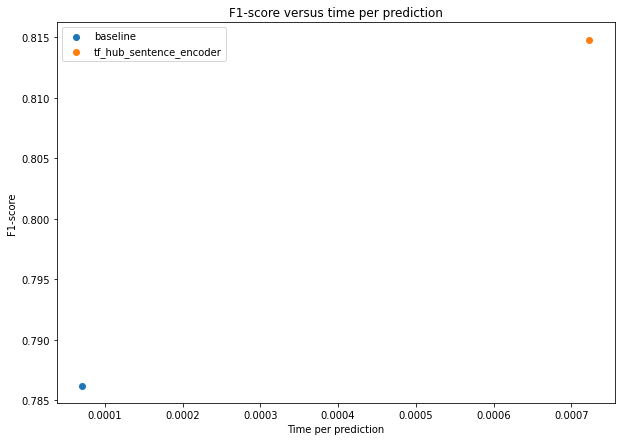

In [162]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_pretrained_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-score");